In [1]:
#add spex templates to selection function
#select the highest SNR spectra of each spectral type i.e 

In [2]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import numba
%matplotlib inline

In [3]:
splat.initializeStandards()

In [4]:
spts=np.array([splat.typeToNum(x) for x in np.arange(16, 42)])

In [5]:
spts

array(['M6.0', 'M7.0', 'M8.0', 'M9.0', 'L0.0', 'L1.0', 'L2.0', 'L3.0',
       'L4.0', 'L5.0', 'L6.0', 'L7.0', 'L8.0', 'L9.0', 'T0.0', 'T1.0',
       'T2.0', 'T3.0', 'T4.0', 'T5.0', 'T6.0', 'T7.0', 'T8.0', 'T9.0',
       'Y0.0', 'Y1.0'], dtype='<U4')

In [6]:
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False)

In [7]:
df=splat_db[splat_db.SPEX_TYPE.isin(spts)]

In [8]:
splat_within_snr=df[df.MEDIAN_SNR.between(5, 200)]

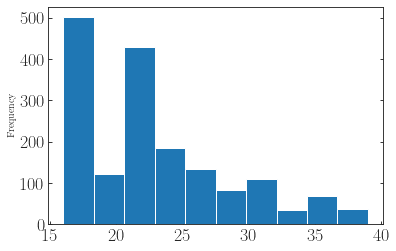

In [9]:
splat_within_snr.SPEX_TYPE.apply(splat.typeToNum).plot(kind='hist', bins=10)

In [10]:
import splat.database as splatdb

Could not import regions, which is required for some of the functionalities of this module.


In [11]:
#binary vetting
folder='/users/caganze/research/wisps/data/'
bindf=pd.read_csv(folder+'/binaries.txt', names=['name', ' '], sep=',')

## Group by spt and pick the Top 30

In [12]:
groups=splat_within_snr.sort_values('MEDIAN_SNR',ascending=False).groupby('SPEX_TYPE')

In [13]:
picks=[]
for g in groups:
    picks.append(g[1].nlargest(20,'MEDIAN_SNR'  ))

In [14]:
df_picks=pd.concat(picks)

Text(0.5, 0, 'SNR')

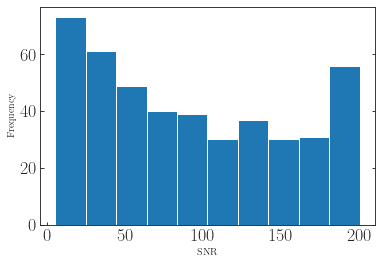

In [15]:
df_picks['MEDIAN_SNR' ].plot(kind='hist')
plt.xlabel('SNR')

In [16]:
import splat

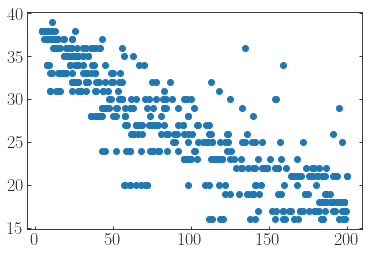

In [17]:
plt.scatter(df_picks.MEDIAN_SNR, df_picks.SPEX_TYPE.apply(splat.typeToNum))

In [18]:

def create_splat_source(filename):
    try:
        #create a wisps spectrum
        #retrieve splat spectrum

        splat_s=splat.getSpectrum(filename=filename)[0]
        spt=splat.typeToNum(splat_s.spex_type)

        #create a source object
        s=wisps.Spectrum( 
                       wave=splat_s.wave.value, 
                       flux=splat_s.flux.value,
                      noise=splat_s.noise.value)
        
        s._splat_spectrum=splat_s

        s.normalize()
        return s
    except OSError:
        return 

In [19]:
import wisps

In [20]:
df_picks['spt']=df_picks.SPEX_TYPE.apply(wisps.make_spt_number)

In [21]:
df_picks=df_picks.sort_values(by='spt')

In [22]:
#df_picks

In [23]:
%%capture
spectra=df_picks.DATA_FILE.apply(create_splat_source)

In [24]:
splat.initializeStandards()

In [25]:
splat.STDS_DWARF_SPEX['L0.0']

SPEX-PRISM spectrum of 2MASP J0345432+254023 (L0.0)

In [26]:
spectra[0].spectral_type

34.0

In [27]:
def plot_sp_sp(s, a, shortname):
    std=splat.STDS_DWARF_SPEX[splat.typeToNum(s.spectral_type)]
    std.normalize(waverange=[1.1, 1.7])
    mask2=np.logical_and(std.wave.value>0.8, std.wave.value<2.5)
    
    mask=np.logical_and(s.wave>0.8, s.wave<2.5)
    a.plot(s.wave[mask], s.flux[mask], label=shortname)
    a.plot(std.wave.value[mask2], std.flux.value[mask2], linestyle='--', label='std')
    
    
    a.set_title("{} ".format(s.spectral_type ))
    a.legend()


In [28]:
(spectra.iloc[0])

anon spectrum

In [29]:
#for idx, s in enumerate(spectra.dropna().values):
#    s.normalize()
#    fig, ax=plt.subplots()
#    plot_sp_sp(s, ax, idx)
    
    
   

In [30]:
def make_wisps(splat_s):
    s=wisps.Spectrum(wave=splat_s.wave.value, 
                       flux=splat_s.flux.value,
                      noise=splat_s.noise.value)
    return s

In [31]:
ydwarfs_stds=pd.read_pickle('/users/caganze/y_standards.pkl')
ydwarfs_data=pd.read_pickle(wisps.LIBRARIES+'/schneider.pkl').spectra.values

In [32]:
t9s=[make_wisps(x) for x in splat.getSpectrum(spt='T9.0')]
t8s=[make_wisps(x) for x in splat.getSpectrum(spt='T8.0')]
y0=[make_wisps(x ) for x in ydwarfs_stds.spec]
y1=[make_wisps(x) for x in ydwarfs_stds.spec]
l3s=[make_wisps(x) for x in splat.getSpectrum(spt='L3.0', binary=False, vlm=True, young=False)]


Retrieving 2 files


Retrieving 14 files


Retrieving 78 files



In [33]:
l3s[:10]

[anon spectrum,
 anon spectrum,
 anon spectrum,
 anon spectrum,
 anon spectrum,
 anon spectrum,
 anon spectrum,
 anon spectrum,
 anon spectrum,
 anon spectrum]

In [34]:
extras=[x for x in np.concatenate([t9s, t8s, y0, y1, l3s[:10]])]

In [35]:
retain=np.append(spectra.dropna().values, extras)
retain=np.append(retain, ydwarfs_data)

In [36]:
import pandas as pd
import wisps 

In [37]:
dfsp=pd.DataFrame()
dfsp['spectra']=retain
dfsp['spt']= [x.spectral_type for x in retain]

In [38]:
import pickle
with open(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl', 'wb') as file:
    pickle.dump(retain,file)

In [39]:
rdpck=pd.read_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl')

In [40]:
bindf['shortname']=bindf.name.apply(str).apply(splat.designationToShortName)

In [41]:
splat_within_snr['shortname']=splat_within_snr.DESIGNATION.apply(splat.designationToShortName)

In [42]:
bsample=splat_within_snr[ ~ (splat_within_snr.shortname.isin(bindf.shortname) |
                             np.isnan(splat_db['PARALLAX']) | (splat_within_snr['SBINARY'] =='Y'))]

In [43]:
bsample=bsample.reset_index(drop=True)

In [44]:
%%capture
bsample_spectra=bsample.DATA_FILE.apply(create_splat_source)

In [45]:
bsample['spectra']=bsample_spectra

In [46]:
from matplotlib.backends.backend_pdf import PdfPages

In [47]:
bsample=bsample.drop_duplicates(subset='shortname').reset_index(drop=True)

In [48]:
dfextr=pd.DataFrame()
#dfextr['NAME']=['J045853.90+643451.9', 'WISE1738+2732', 'WISE1738+2732']
dfextr['SPEX_TYPE']=[x.spectral_type for x in extras]
#dfextr['shortname']=['J045853.90+643451.9', 'WISE1738+2732', 'WISE1738+2732']
dfextr['spectra']=extras


In [49]:
#add T9 and y dwarfs
#dfextr
bspl=bsample.append(dfextr, ignore_index=True, verify_integrity=True, sort=True)

In [50]:
%%capture
with PdfPages(wisps.OUTPUT_FIGURES+'/multipage_binaries.pdf') as pdf:
    
    for g in np.array_split(bspl, int(len(bspl)/4)):
        fig, ax=plt.subplots(ncols=2, nrows=2)
        
        plot_sp_sp(g.spectra.iloc[0], ax[0][0], g.shortname.iloc[0])
        plot_sp_sp(g.spectra.iloc[1], ax[0][1],  g.shortname.iloc[1])
        plot_sp_sp(g.spectra.iloc[2], ax[1][0],  g.shortname.iloc[2])
        plot_sp_sp(g.spectra.iloc[3], ax[1][1],  g.shortname.iloc[3])

        pdf.savefig() 
        plt.close()

In [51]:
bspl.reset_index(drop=True).to_pickle(wisps.OUTPUT_FILES+'/binary_spex.pkl')

In [52]:
(bspl[['SOURCE_KEY', 'NAME', 'DESIGNATION', 'RA', 'DEC', 'DISCOVERY_REFERENCE',
       'OPT_TYPE', 'NIR_TYPE', 'LIT_TYPE',
       'J_2MASS',
       'H_2MASS_E', 'GRAVITY_CLASS_NIR','BINARY', 'SBINARY','SIMBAD_NAME', 'SIMBAD_SPT',
       'SIMBAD_SPT_REF', 'PARALLAX', 'PARALLAX_E', 'DISTANCE',
       'SPEX_GRAVITY_CLASSIFICATION', 
       'shortname']]).to_excel(wisps.OUTPUT_FILES+"/nonbinaries.xlsx")  

In [53]:
type(bsample.spectra.iloc[0])

wisps.data_analysis.spectrum_tools.Spectrum